# Creating a LlamaIndex RAG Pipeline with NL2SQL and Metadata Filtering!

We'll be putting together a system for querying both qualitative and quantitative data using LlamaIndex.

The acitvities will be broken down as follows:

- 🤝 Breakout Room #1
  - Task 1: Load Dependencies
  - Task 2: Set Env Variables and Set Up WandB Callback
  - Task 3: Initialize Settings
  - Task 4: Semantic RAG Pipeline with Metadata Filtering
- 🤝 Breakout Room #2
  - Task 1: Quantitative RAG Pipeline with NL2SQL Tooling
  - Task 2: Combined RAG Pipeline

Before we get started, however, a quick note on terminology.


### A note on terminology:

You'll notice that there are quite a few similarities between LangChain and LlamaIndex. LlamaIndex can largely be thought of as an extension to LangChain, in some ways - but they moved some of the language around. Let's spend a few moments disambiguating the language.

- `QueryEngine` -> `LCEL Chain`:
  -  `QueryEngine` is just LlamaIndex's way of indicating something is an LLM "chain" on top of a retrieval system
- `OpenAIAgent` vs. `Agent`:
  - The two agents have the same fundamental pattern: Decide which of a list of tools to use to answer a user's query.
  - `OpenAIAgent` (LlamaIndex's primary agent) does not need to rely on an agent excecutor due to the fact that it is leveraging OpenAI's [functional api](https://openai.com/blog/function-calling-and-other-api-updates) which allows the agent to interface "directly" with the tools instead of operating through an intermediary application process.

There is, however, a much large terminological difference when it comes to discussing data.

##### Nodes vs. Documents

As you're aware of from the previous weeks assignments, there's an idea of `documents` in NLP which refers to text objects that exist within a corpus of documents.

LlamaIndex takes this a step further and reclassifies `documents` as `nodes`. Confusingly, it refers to the `Source Document` as simply `Documents`.

The `Document` -> `node` structure is, almost exactly, equivalent to the `Source Document` -> `Document` structure found in LangChain - but the new terminology comes with some clarity about different structure-indices.

We won't be leveraging those structured indicies today, but we will be leveraging a "benefit" of the `node` structure that exists as a default in LlamaIndex, which is the ability to quickly filter nodes based on their metadata.

![image](https://i.imgur.com/B1QDjs5.png)

# 🤝 Breakout Room #1

## BOILERPLATE

This is only relevant when running the code in a Jupyter Notebook.

In [1]:
import nest_asyncio

nest_asyncio.apply()

import logging
import sys

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

## Task 1: Load Dependencies

Let's grab our core `llama-index` library, as well as OpenAI's Python SDK.

We'll be leveraging OpenAI's suite of APIs to power our RAG pipelines today.

> NOTE: You can safely ignore any pip errors that occur during the running of these cells.

In [2]:
!pip install -qU llama-index openai

We'll be using [Weights and Biases](https://docs.wandb.ai/guides/prompts) (WandB) again for today's notebook!

In [3]:
!pip install -qU wandb llama-index-callbacks-wandb

We'll be collecting our semantic data from Wikipedia - and so will need the [Wikipedia Reader](https://github.com/run-llama/llama_index/tree/main/llama-index-integrations/readers/llama-index-readers-wikipedia)!

In [4]:
!pip install -qU wikipedia llama-index-readers-wikipedia

Our vector database today will be powered by [ChromaDB](https://github.com/chroma-core/chroma) and so we'll need that package as well!

In [5]:
!pip install -qU chromadb llama-index-vector-stores-chroma

Finally, we'll need to grab a few dependencies related to our quantitative data!

In [6]:
!pip install -q -U sqlalchemy pandas

We'll grab some additional miscellaneous dependencies here.

In [7]:
!pip install -U -q tiktoken==0.4.0 sentence-transformers==2.2.2 pydantic==1.10.11

## Task 2: Set Env Variables and Set Up WandB Callback

Let's set our API keys for both OpenAI and WandB!

In [8]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key: ")

In [9]:
os.environ["WANDB_API_KEY"] = getpass.getpass("WandB API Key: ")

We'll also need to set a callback handler for WandB to ensure smooth operation of our traces!

In [10]:
import llama_index
from llama_index.core import set_global_handler

set_global_handler("wandb", run_args={"project": "aie1-llama-index-demo"})
wandb_callback = llama_index.core.global_handler

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Streaming LlamaIndex events to W&B at https://wandb.ai/simonrmonk/aie1-llama-index-demo/runs/jgwq7afw
wandb: `WandbCallbackHandler` is currently in beta.
wandb: Please report any issues to https://github.com/wandb/wandb/issues with the tag `llamaindex`.


### Task 3: Settings

LlamaIndex lets us set global settings which we can use to influence the default behaviour of our components.

Let's set our LLM and our Embedding Model!

In [12]:
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.core import Settings

Settings.llm = OpenAI(model="gpt-3.5-turbo")
Settings.embed_model = OpenAIEmbedding(model="text-embedding-3-small")

## Task 4: Semantic RAG Pipeline with Metadata Filtering

Now we can get to work creating our semantic `QueryEngine`!

We'll start, as we normally do, by grabbing some data.

> NOTE: Remember that a query engine is just a different word for a chain!

### Data Collection

We're just going to be pulling information straight from Wikipedia using the built in `WikipediaReader`.

> NOTE: Setting `auto_suggest=False` ensures we run into fewer auto-correct based errors.

In [13]:
from llama_index.readers.wikipedia import WikipediaReader

movie_list = ["Dune (2021 film)", "Dune: Part Two"]

wiki_docs = WikipediaReader().load_data(pages=movie_list, auto_suggest=False)

### Initializing our VectorStoreIndex with ChromaDB

ChromaDB is a locally hostable and open-source vector database solution.

It offers powerful features like metadata filtering out of the box, and will suit our needs well today!

We'll start by creating our local `EphemeralClient()` (in-memory and not meant for production use-cases) and our collection.

Then we'll create our `VectorStore` and `StorageContext` which will allow us to create an empty `VectorStoreIndex` which we will be able to add nodes to later!

In [15]:
from llama_index.vector_stores.chroma import ChromaVectorStore
import chromadb

chroma_client = chromadb.EphemeralClient()
chroma_collection = chroma_client.create_collection("dune-v0")

In [16]:
from llama_index.core import VectorStoreIndex
from llama_index.core import StorageContext

vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
storage_context = StorageContext.from_defaults(vector_store=vector_store)
index = VectorStoreIndex.from_documents([], storage_context=storage_context)

wandb: Logged trace tree to W&B.


### Node Construction

Now we will loop through our documents and metadata and construct nodes.

We'll make sure to explicitly associate our nodes with their respective movie so we can filter by the movie title in the upcoming cells.

> NOTE: You can safely ignore any WARNINGs in the following cell.

In [17]:
from llama_index.core import SimpleDirectoryReader
from llama_index.core.ingestion import IngestionPipeline
from llama_index.core.node_parser import TokenTextSplitter
from llama_index.core.extractors import TitleExtractor

pipeline = IngestionPipeline(transformations=[TokenTextSplitter()])

for movie, wiki_doc in zip(movie_list, wiki_docs):
    nodes = pipeline.run(documents=wiki_docs)
    for node in nodes:
        node.metadata = {"title" : movie}
    index.insert_nodes(nodes)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
Insert of existing embedding ID: ca5f28e8-2653-4767-a5a0-ecb6794a3741
Insert of existing embedding ID: 86512705-5d09-477e-88a6-7269d1c883f4
Insert of existing embedding ID: f2e88d3a-1170-487f-b828-519d27ac8a19
Insert of existing embedding ID: 65033f1d-cbd9-41f7-a9b1-19a1d89e863d
Insert of existing embedding ID: 01be5e92-bda2-46b9-868a-814f284fcbe5
Insert of existing embedding ID: ecfed355-7824-411a-8340-b0c4affc35b9
Insert of existing embedding ID: ef78eeb3-47db-404b-99a3-be9045a20db6
Insert of existing embedding ID: 08fe5074-8281-4999-9141-e66c2fcb15ef
Insert of existing embedding ID: 2caad9ea-7bb9-47bf-85fb-2b4bc18c2e18
Insert of existing embedding ID: 7033793e-76ad-4994-

####❓ Question #1:

What `metadata` fields will the nodes in our index have?

Answer: Just the title of the movie

Please write the code to find this information.

In [20]:
node.metadata

{'title': 'Dune: Part Two'}

### Persisting and Loading Stored Index with Weights and Biases

Now we can utilize a powerful feature of Weights and Biases - index and artifact versioning!

We can persist our index to WandB to be used and loaded later!

In [21]:
wandb_callback.persist_index(index, index_name="dune-index-chromadb")

wandb: Adding directory to artifact (/home/smonk/workspace/AI-Engineering/Week 4/Day 2/wandb/run-20240312_223547-jgwq7afw/files/storage)... 

Done. 0.2s


Now we can load our index from WandB, which is a truly powerful tool!

In [22]:
from llama_index.core import load_index_from_storage

storage_context = wandb_callback.load_storage_context(
    artifact_url="simonrmonk/aie1-llama-index-demo/dune-index-chromadb:v0"
)

wandb:   4 of 4 files downloaded.  


####❓ Question #2:

Provide a screenshot of your index version history as shown in WandB.

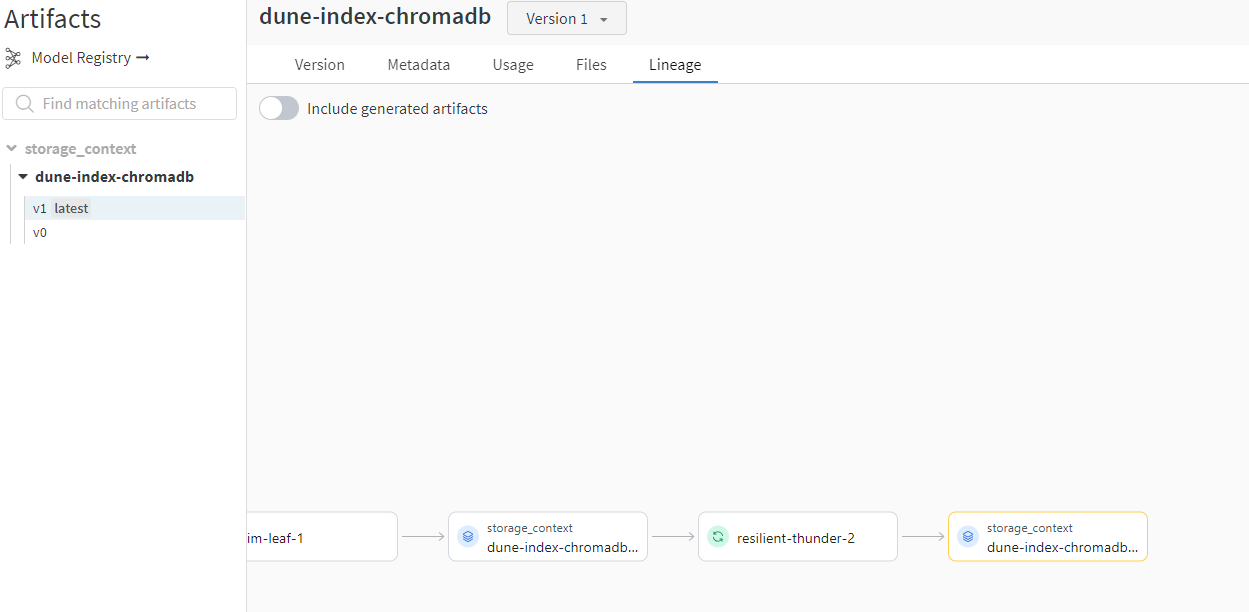

### Auto Retriever Functional Tool

This tool will leverage OpenAI's functional endpoint to select the correct metadata filter and query the filtered index - only looking at nodes with the desired metadata.

A simplified diagram: ![image](https://i.imgur.com/AICDPav.png)

First, we need to create our `VectoreStoreInfo` object which will hold all the relevant metadata we need for each component (in this case title metadata).

Notice that you need to include it in a text list.

In [23]:
from llama_index.core.tools import FunctionTool
from llama_index.core.vector_stores.types import (
    VectorStoreInfo,
    MetadataInfo,
    ExactMatchFilter,
    MetadataFilters,
)
from llama_index.core.retrievers import VectorIndexRetriever
from llama_index.core.query_engine import RetrieverQueryEngine

from typing import List, Tuple, Any
from pydantic import BaseModel, Field

top_k = 3

vector_store_info = VectorStoreInfo(
    content_info="semantic information about movies",
    metadata_info=[MetadataInfo(
        name="title",
        type="str",
        description="title of the movie, one of ['Dune (2021 film)', 'Dune: Part 2']",
    )]
)

Now we'll create our base PyDantic object that we can use to ensure compatability with our application layer. This verifies that the response from the OpenAI endpoint conforms to this schema.

In [24]:
class AutoRetrieveModel(BaseModel):
    query: str = Field(..., description="natural language query string")
    filter_key_list: List[str] = Field(
        ..., description="List of metadata filter field names"
    )
    filter_value_list: List[str] = Field(
        ...,
        description=(
            "List of metadata filter field values (corresponding to names specified in filter_key_list)"
        )
    )

Now we can build our function that we will use to query the functional endpoint.

In [25]:
def auto_retrieve_fn(
    query: str, filter_key_list: List[str], filter_value_list: List[str]
):
    """Auto retrieval function.

    Performs auto-retrieval from a vector database, and then applies a set of filters.

    """
    query = query or "Query"

    exact_match_filters = [
        ExactMatchFilter(key=k, value=v)
        for k, v in zip(filter_key_list, filter_value_list)
    ]
    retriever = VectorIndexRetriever(
        index, filters=MetadataFilters(filters=exact_match_filters), top_k=top_k
    )
    query_engine = RetrieverQueryEngine.from_args(retriever)

    response = query_engine.query(query)
    return str(response)

Now we need to wrap our system in a tool in order to integrate it into the larger application.

Source Code Here:
- [`FunctionTool`](https://github.com/jerryjliu/llama_index/blob/d24767b0812ac56104497d8f59095eccbe9f2b08/llama_index/tools/function_tool.py#L21)

In [26]:
description = f"""\
Use this tool to look up semantic information about films.
The vector database schema is given below:
{vector_store_info.json()}
"""

auto_retrieve_tool = FunctionTool.from_defaults(
    fn=auto_retrieve_fn,
    name="semantic-film-info",
    description=description,
    fn_schema=AutoRetrieveModel
)

####❓ Question #3:

Is the text in the description of our `FunctionTool` important or not? Please explain your answer.

All that's left to do is attach the tool to an OpenAIAgent and let it rip!

Source Code Here:
- [`OpenAIAgent`](https://github.com/jerryjliu/llama_index/blob/d24767b0812ac56104497d8f59095eccbe9f2b08/llama_index/agent/openai_agent.py#L361)

In [27]:
from llama_index.agent.openai import OpenAIAgent

agent = OpenAIAgent.from_tools(
    tools=[auto_retrieve_tool],
    verbose=True,
)

In [28]:
response = agent.chat("Who starred in the 2021 film?")
print(str(response))

Added user message to memory: Who starred in the 2021 film?
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Calling Function ===
Calling function: semantic-film-info with args: {"query":"cast of the 2021 film","filter_key_list":["title"],"filter_value_list":["Dune (2021 film)"]}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Got output: The cast of the 2021 film "Dune" includes Timothée Chalamet, Rebecca Ferguson, Dave Bautista, Stellan Skarsgård, Charlotte Rampling, Oscar Isaac, Zendaya, Javier Bardem, Josh Brolin, Jason Momoa, David Dastmalchian, Stephen McKinley Henderson, Chang C

wandb: Logged trace tree to W&B.


The 2021 film "Dune" starred Timothée Chalamet, Rebecca Ferguson, Dave Bautista, Stellan Skarsgård, Charlotte Rampling, Oscar Isaac, Zendaya, Javier Bardem, Josh Brolin, Jason Momoa, David Dastmalchian, Stephen McKinley Henderson, Chang Chen, Benjamin Clementine, and Sharon Duncan-Brewster.


# 🤝 Breakout Room #2

## Task 1: Quantitative RAG Pipeline with NL2SQL Tooling

We'll walk through the steps of creating a natural language to SQL system in the following section.

> NOTICE: This does not have parsing on the inputs or intermediary calls to ensure that users are using safe SQL queries. Use this with caution in a production environment without adding specific guardrails from either side of the application.

The next few steps should be largely straightforward, we'll want to:

1. Read in our `.csv` files into `pd.DataFrame` objects
2. Create an in-memory `sqlite` powered `sqlalchemy` engine
3. Cast our `pd.DataFrame` objects to the SQL engine
4. Create an `SQLDatabase` object through LlamaIndex
5. Use that to create a `QueryEngineTool` that we can interact with through the `NLSQLTableQueryEngine`!

If you get stuck, please consult the documentation.

In [29]:
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/dune1.csv

--2024-03-12 22:52:54--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/dune1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133391 (130K) [text/plain]
Saving to: ‘dune1.csv.1’

dune1.csv.1         100%[===================>] 130.26K  --.-KB/s    in 0.003s  

2024-03-12 22:52:54 (37.1 MB/s) - ‘dune1.csv.1’ saved [133391/133391]



In [30]:
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/dune2.csv

--2024-03-12 22:52:56--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/dune2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111843 (109K) [text/plain]
Saving to: ‘dune2.csv.1’

dune2.csv.1         100%[===================>] 109.22K  --.-KB/s    in 0.003s  

2024-03-12 22:52:56 (36.4 MB/s) - ‘dune2.csv.1’ saved [111843/111843]



#### Read `.csv` Into Pandas

In [31]:
import pandas as pd

dune1_df = pd.read_csv("./dune1.csv")
dune2_df = pd.read_csv("./dune2.csv")

In [32]:
dune1_df

,Unnamed: 0,Review_Date,Author,Rating,Review_Title,Review,Review_Url
0,0,13 September 2021,FabledGentleman,9.0,DUNE - A Great Modern Sci-Fi\n,Denis Villeneuve has accomplished what was con...,/review/rw7338282/?ref_=tt_urv
1,1,23 October 2021,Sleepin_Dragon,10.0,"My movie of 2021, so far.\n",It's been amazing being back in cinemas after ...,/review/rw7475243/?ref_=tt_urv
2,2,22 October 2021,classicsoncall,9.0,"""He shall know your ways as though born to th...",It's been some time since I've read the Frank ...,/review/rw7469852/?ref_=tt_urv
3,3,17 September 2021,851222,8.0,Amazing cinematic experience\n,Greetings from Lithuania.,/review/rw7353830/?ref_=tt_urv
4,4,22 October 2021,Hitchcoc,8.0,The Beginning\n,"Having read the book a hundred years ago, it t...",/review/rw7468495/?ref_=tt_urv
...,...,...,...,...,...,...,...
269,269,8 October 2021,HawraaF96,9.0,A must watch in theatre for the first time.\n,I really enjoyed the experience. I love movies...,/review/rw7423452/?ref_=tt_urv
270,270,14 February 2023,LeonLouisRicci,4.0,Eye-Sore that Makes the Eyes-Sore...Watching ...,All the Irritating an Distracting 21st Century...,/review/rw8870290/?ref_=tt_urv
271,271,1 October 2021,b4al,10.0,Best blockbuster for years\n,Real pleasure to discover Dune in Villeneuve v...,/review/rw7399205/?ref_=tt_urv
272,272,14 September 2021,barthelemy-bauters,10.0,"Dune, an absolute masterpiece\n","Just got out of the theater, and WOW.",/review/rw7344688/?ref_=tt_urv


#### Create SQLAlchemy engine with SQLite

In [33]:
from sqlalchemy import create_engine

engine = create_engine("sqlite+pysqlite:///:memory:")

#### Convert `pd.DataFrame` to SQL tables

In [34]:
dune1_df.to_sql(
    "Dune (2021 film)",
    engine
)

274

In [35]:
dune2_df.to_sql(
    "Dune: Part 2",
    engine
)

175

#### Construct a `SQLDatabase` index

Source Code Here:
- [`SQLDatabase`](https://github.com/jerryjliu/llama_index/blob/d24767b0812ac56104497d8f59095eccbe9f2b08/llama_index/langchain_helpers/sql_wrapper.py#L9)

In [37]:
from llama_index.core import SQLDatabase

sql_database = SQLDatabase(
    engine=engine,
    include_tables=["Dune (2021 film)", "Dune: Part 2"]
)

#### Create the NLSQLTableQueryEngine interface for all added SQL tables

Source Code Here:
- [`NLSQLTableQueryEngine`](https://github.com/jerryjliu/llama_index/blob/d24767b0812ac56104497d8f59095eccbe9f2b08/llama_index/indices/struct_store/sql_query.py#L75C1-L75C1)

In [38]:
from llama_index.core.indices.struct_store.sql_query import NLSQLTableQueryEngine

sql_query_engine = NLSQLTableQueryEngine(
    sql_database=sql_database,
    tables=["Dune (2021 film)", "Dune: Part 2"],
)

#### Wrap It All Up in a `QueryEngineTool`

You'll want to ensure you have a descriptive...description.

An example is provided here:

```
Useful for translating a natural language query into a SQL query over a table containing:
John Wick 1, containing information related to reviews of the first John Wick movie, called John Wick
John Wick 2, containing information related to reviews of the second John Wick movie, called John Wick: Chapter 2
John Wick 3, containing information related to reviews of the third John Wick movie, called John Wick: Chatper 3 - Parabellum
John Wick 4, containing information related to reviews of the fourth John Wick movie, called John Wick: Chatper 4
```

Sorce Code Here:

- [`QueryEngineTool`](https://github.com/jerryjliu/llama_index/blob/d24767b0812ac56104497d8f59095eccbe9f2b08/llama_index/tools/query_engine.py#L13)

####🏗️ Activity #1:

Please write a Natural Language Description for the tables that we are using today.

In [39]:
DESCRIPTION = """\
    Useful for querying information about movie reviews for two Dune movies, specifically the 2021 film "Dune" and its sequel "Dune: Part 2".
    Data includes, movie ratings.
"""

In [40]:
from llama_index.core.tools.query_engine import QueryEngineTool

sql_tool = QueryEngineTool.from_defaults(
    query_engine=sql_query_engine,
    name="sql-query",
    description=DESCRIPTION,
)

In [41]:
agent = OpenAIAgent.from_tools(
    tools=[sql_tool],
    verbose=True
)

In [42]:
response = agent.chat("What is the average rating of the 2nd Dune movie?")

Added user message to memory: What is the average rating of the 2nd Dune movie?
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Calling Function ===
Calling function: sql-query with args: {"input":"average rating of Dune: Part 2"}
INFO:llama_index.core.indices.struct_store.sql_retriever:> Table desc str: Table 'Dune (2021 film)' has columns: index (BIGINT), Unnamed: 0 (BIGINT), Review_Date (TEXT), Author (TEXT), Rating (FLOAT), Review_Title (TEXT), Review (TEXT), Review_Url (TEXT), and foreign keys: .

Table 'Dune: Part 2' has columns: index (BIGINT), Unnamed: 0 (BIGINT), Review_Date (TEXT), Author (TEXT), Rating (FLOAT), Review_Title (TEXT), Review (TEXT), Review_Url (TEXT), and foreign keys: .
> Table desc str: Table 'Dune (2021 film)' has columns: index (BIGINT), Unnamed: 0 (BIGINT), Review_Date (TEXT), Author (TEXT), Rating (FLOAT), Review_Title (TEXT), Rev

wandb: Logged trace tree to W&B.


In [40]:
print(str(response))

The average rating for the 2nd Dune movie, "Dune: Part 2," is approximately 8.71.


### Task 2: Combined RAG Pipeline

Now, we can simply add our tools into the `OpenAIAgent`, and off we go!

In [43]:
dune_agent = OpenAIAgent.from_tools(
    tools=[auto_retrieve_tool, sql_tool],
    verbose=True
)

In [44]:
response = dune_agent.chat("What is the lowest rating of the 1st film?")

Added user message to memory: What is the lowest rating of the 1st film?
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Calling Function ===
Calling function: sql-query with args: {"input":"SELECT MIN(rating) FROM movie_reviews WHERE film_title = 'Dune (2021 film)'"}
INFO:llama_index.core.indices.struct_store.sql_retriever:> Table desc str: Table 'Dune (2021 film)' has columns: index (BIGINT), Unnamed: 0 (BIGINT), Review_Date (TEXT), Author (TEXT), Rating (FLOAT), Review_Title (TEXT), Review (TEXT), Review_Url (TEXT), and foreign keys: .

Table 'Dune: Part 2' has columns: index (BIGINT), Unnamed: 0 (BIGINT), Review_Date (TEXT), Author (TEXT), Rating (FLOAT), Review_Title (TEXT), Review (TEXT), Review_Url (TEXT), and foreign keys: .
> Table desc str: Table 'Dune (2021 film)' has columns: index (BIGINT), Unnamed: 0 (BIGINT), Review_Date (TEXT), Author (TEXT), Ra

wandb: Logged trace tree to W&B.


In [43]:
print(str(response))

The lowest rating for the film "Dune (2021 film)" is 1.0.


In [44]:
response = dune_agent.chat("What planet does the 1st Dune movie take place on?")

Added user message to memory: What planet does the 1st Dune movie take place on?
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Calling Function ===
Calling function: semantic-film-info with args: {"query":"planet where the 1st Dune movie takes place","filter_key_list":["title"],"filter_value_list":["Dune (2021 film)"]}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Got output: Arrakis

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


wandb: Logged trace tree to W&B.


In [ ]:
print(str(response))

The 1st Dune movie, "Dune (2021 film)," takes place on the planet Arrakis.


In [45]:
response = dune_agent.chat("Calculate the average review of each movie - and then discuss how the average review changed over time.")

Added user message to memory: Calculate the average review of each movie - and then discuss how the average review changed over time.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Calling Function ===
Calling function: sql-query with args: {"input": "SELECT AVG(rating) FROM films WHERE title = 'Dune (2021 film)';"}
INFO:llama_index.core.indices.struct_store.sql_retriever:> Table desc str: Table 'Dune (2021 film)' has columns: index (BIGINT), Unnamed: 0 (BIGINT), Review_Date (TEXT), Author (TEXT), Rating (FLOAT), Review_Title (TEXT), Review (TEXT), Review_Url (TEXT), and foreign keys: .

Table 'Dune: Part 2' has columns: index (BIGINT), Unnamed: 0 (BIGINT), Review_Date (TEXT), Author (TEXT), Rating (FLOAT), Review_Title (TEXT), Review (TEXT), Review_Url (TEXT), and foreign keys: .
> Table desc str: Table 'Dune (2021 film)' has columns: index (BIGINT), Unnamed:

wandb: Logged trace tree to W&B.


In [46]:
print(str(response))

The average review ratings for each movie are as follows:
- "Dune (2021 film)": 8.34
- "Dune: Part 2": 8.71

Discussing how the average review changed over time, we can see that the sequel "Dune: Part 2" has a slightly higher average rating compared to the first film "Dune (2021 film)". This indicates that the audience reception and appreciation for the sequel may have been slightly better than the first movie.


####❓ Question #4:

How can you verify which tool was used for which query?

In [45]:
wandb_callback.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job
